## Time Series: Climate Data
![climate](https://images.pexels.com/photos/2969/climate-cold-glacier-iceberg.jpg?auto=compress&cs=tinysrgb&dpr=2&h=750&w=1260)
**Objectives:**
- list methods to adjust data for time series
- define the vocabulary of lagging, moving averages, and differencing
- replicate the process in google sheets and in python

**Question**: What are numbers we'd want to model over time?

**Problem:** All our tools aren't natively prepared to handle time series data. We need to make a lot of adjustments to our data. 

### Set up environment and tool set 

In [6]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [8, 3]
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels

import scipy
from scipy.stats import pearsonr

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
print(matplotlib.__version__)
print(pd.__version__)
print(np.__version__)
print(statsmodels.__version__)
print(scipy.__version__)

3.0.3
0.24.2
1.16.2
0.9.0
1.2.1


Data obtained from `https://datahub.io/core/global-temp#data`<br>
Looks like original source is obtained from `https://www.ncdc.noaa.gov/cag/global/time-series`

Data are included from the GISS Surface Temperature (GISTEMP) analysis and the global component of Climate at a Glance (GCAG)

### Obtain and visualize data

In [3]:
## data obtained from https://datahub.io/core/global-temp#data
df = pd.read_csv("https://pkgstore.datahub.io/core/global-temp/annual_csv/data/a26b154688b061cdd04f1df36e4408be/annual_csv.csv")
df.head()

,Source,Year,Mean
0,GCAG,2016,0.9363
1,GISTEMP,2016,0.9900
2,GCAG,2015,0.8998
3,GISTEMP,2015,0.8700
4,GCAG,2014,0.7408


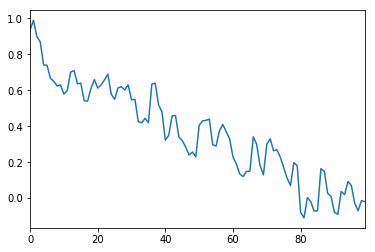

In [5]:
df.Mean[:100].plot()
plt.show()

### Exercise: what is wrong with the data and plot above? How can we fix this?

In [7]:
df = df.pivot(index='Year', columns='Source', values='Mean')

In [8]:
df.head()

Source,GCAG,GISTEMP
Year,,
1880,-0.1148,-0.20
1881,-0.0628,-0.12
1882,-0.0648,-0.10
1883,-0.1424,-0.21
1884,-0.2009,-0.28


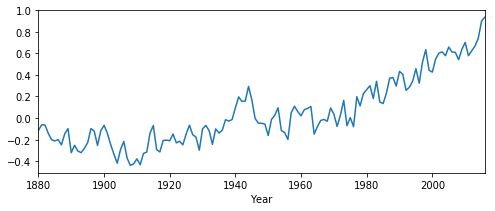

In [10]:
df.GCAG.plot()
plt.show()

In [11]:
type(df.index)

pandas.core.indexes.numeric.Int64Index

### Exercise: how can we make the index more time aware?

In [12]:
df.index = pd.to_datetime(df.index, format='%Y')

In [13]:
df.head()

Source,GCAG,GISTEMP
Year,,
1880-01-01,-0.1148,-0.20
1881-01-01,-0.0628,-0.12
1882-01-01,-0.0648,-0.10
1883-01-01,-0.1424,-0.21
1884-01-01,-0.2009,-0.28


In [14]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

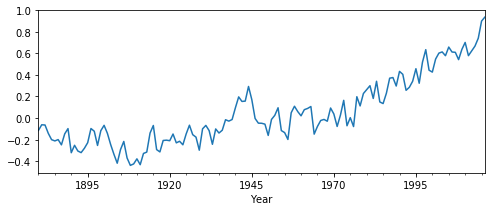

In [16]:
df.GCAG.plot()
plt.show()

In [17]:
df['1880']

Source,GCAG,GISTEMP
Year,,
1880-01-01,-0.1148,-0.2


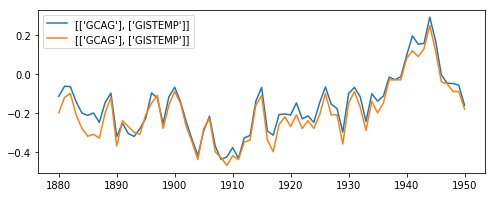

In [22]:
plt.plot(df['1880':'1950'][['GCAG', 'GISTEMP']])
plt.legend()
plt.show()

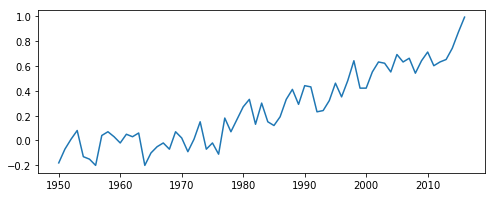

In [25]:
plt.plot(df['1950':][['GISTEMP']])
plt.show()

## Logging

`np.log()`

In [27]:
df['GCAG_log'] = np.log(df.GCAG) # taking the actual log transformation
df['GISTEMP_log'] = np.log(df.GISTEMP)
df.tail(10)

C:\Users\Michelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\Users\Michelle\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log
Year,,,,
2007-01-01,0.6100,0.66,-0.494296,-0.415515
2008-01-01,0.5419,0.54,-0.612674,-0.616186
2009-01-01,0.6367,0.64,-0.451457,-0.446287
2010-01-01,0.7014,0.71,-0.354677,-0.342490
2011-01-01,0.5788,0.60,-0.546798,-0.510826
2012-01-01,0.6240,0.63,-0.471605,-0.462035
2013-01-01,0.6679,0.65,-0.403617,-0.430783
2014-01-01,0.7408,0.74,-0.300025,-0.301105
2015-01-01,0.8998,0.87,-0.105583,-0.139262


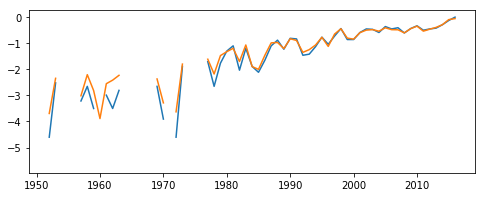

In [35]:
plt.plot(df['1950':][['GISTEMP_log','GCAG_log']])
plt.show()

## Lagging

`shift()` [shift documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html)

In [31]:
df['GCAG_lag1'] = df.GCAG.shift()

In [32]:
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1
Year,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424


In [37]:
df['GISTEMP_lag1'] = df.GISTEMP.shift()
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1,GCAG_diff1,GISTEMP_lag1
Year,,,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148,0.0520,-0.20
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628,-0.0020,-0.12
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648,-0.0776,-0.10
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424,-0.0585,-0.21



## Differencing

`diff()` [diff documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html)

#### First order difference

In [44]:
df['GCAG_diff1']=df.GCAG.diff()
df['GISTEMP_diff1'] = df.GISTEMP.diff()

In [45]:
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1,GCAG_diff1,GISTEMP_lag1,GCAG_diff2,GISTEMP_diff1
Year,,,,,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148,0.0520,-0.20,NaN,0.08
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628,-0.0020,-0.12,-0.0540,0.02
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648,-0.0776,-0.10,-0.0756,-0.11
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424,-0.0585,-0.21,0.0191,-0.07


#### Second order difference

In [46]:
df['GCAG_diff2']=df.GCAG_diff1.diff()
df['GISTEMP_diff2'] = df.GISTEMP_diff1.diff()

In [47]:
df.head()

Source,GCAG,GISTEMP,GCAG_log,GISTEMP_log,GCAG_lag1,GCAG_diff1,GISTEMP_lag1,GCAG_diff2,GISTEMP_diff1,GISTEMP_diff2
Year,,,,,,,,,,
1880-01-01,-0.1148,-0.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1881-01-01,-0.0628,-0.12,NaN,NaN,-0.1148,0.0520,-0.20,NaN,0.08,NaN
1882-01-01,-0.0648,-0.10,NaN,NaN,-0.0628,-0.0020,-0.12,-0.0540,0.02,-0.06
1883-01-01,-0.1424,-0.21,NaN,NaN,-0.0648,-0.0776,-0.10,-0.0756,-0.11,-0.13
1884-01-01,-0.2009,-0.28,NaN,NaN,-0.1424,-0.0585,-0.21,0.0191,-0.07,0.04


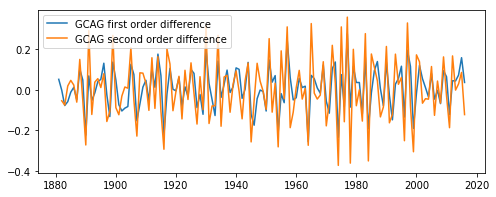

In [51]:
plt.plot(df.index, df.GCAG_diff1, label='GCAG first order difference')
plt.plot(df.index, df.GCAG_diff2, label='GCAG second order difference')
plt.legend(loc='upper left')
plt.show()

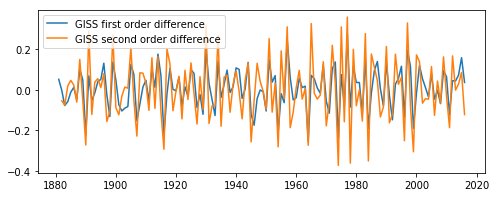

In [50]:
plt.plot(df.index, df.GCAG_diff1, label='GISS first order difference')
plt.plot(df.index, df.GCAG_diff2, label='GISS second order difference')
plt.legend(loc='upper left')
plt.show()

## Moving Average

![img](img/MA.png)

`rolling()`  [rolling here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)

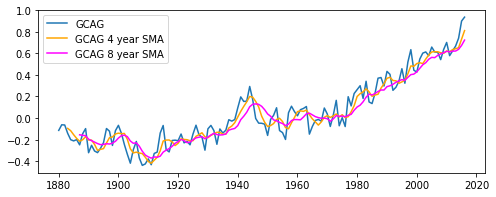

In [53]:
rolling_mean = df.GCAG.rolling(window=4).mean()
rolling_mean2 = df.GCAG.rolling(window=8).mean()
plt.plot(df.index, df.GCAG, label = 'GCAG')
plt.plot(df.index, rolling_mean, label='GCAG 4 year SMA', color='orange')
plt.plot(df.index, rolling_mean2, label='GCAG 8 year SMA', color='magenta')
plt.legend(loc='upper left')
plt.show()

### Exercise: How strongly do these measurements correlate contemporaneously? What about with a time lag?

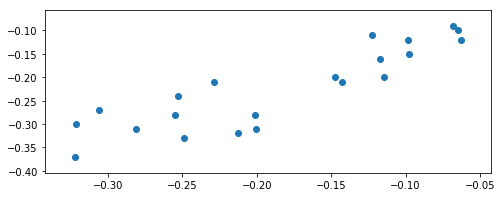

In [56]:
plt.scatter(df['1880':'1900'][['GCAG']], df['1880':'1900'][['GISTEMP']])
plt.show()

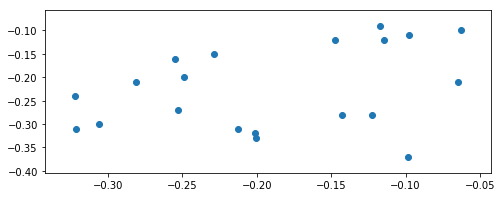

In [57]:
plt.scatter(df['1880':'1899'][['GCAG']], df['1881':'1900'][['GISTEMP']])
plt.show()

In [66]:
pearsonr(df['1880':'1899'].GCAG, df['1881':'1900'].GISTEMP)

(0.345481359365847, 0.1357146858328232)

In [67]:
df['1880':'1899'][['GCAG']].head()

Source,GCAG
Year,
1880-01-01,-0.1148
1881-01-01,-0.0628
1882-01-01,-0.0648
1883-01-01,-0.1424
1884-01-01,-0.2009


In [68]:
df['1881':'1900'][['GISTEMP']].head()

Source,GISTEMP
Year,
1881-01-01,-0.12
1882-01-01,-0.10
1883-01-01,-0.21
1884-01-01,-0.28
1885-01-01,-0.32


In [130]:
df.GISTEMP.values

array([-0.2 , -0.12, -0.1 , -0.21, -0.28, -0.32, -0.31, -0.33, -0.2 ,
       -0.12, -0.37, -0.24, -0.27, -0.3 , -0.31, -0.21, -0.15, -0.11,
       -0.28, -0.16, -0.09, -0.15, -0.27, -0.35, -0.44, -0.28, -0.23,
       -0.4 , -0.43, -0.47, -0.42, -0.44, -0.35, -0.34, -0.16, -0.11,
       -0.34, -0.4 , -0.26, -0.22, -0.27, -0.21, -0.28, -0.24, -0.28,
       -0.21, -0.1 , -0.21, -0.21, -0.36, -0.15, -0.09, -0.17, -0.29,
       -0.14, -0.2 , -0.15, -0.03, -0.03, -0.03,  0.08,  0.12,  0.09,
        0.13,  0.25,  0.12, -0.04, -0.05, -0.09, -0.09, -0.18, -0.07,
        0.01,  0.08, -0.13, -0.15, -0.2 ,  0.04,  0.07,  0.03, -0.02,
        0.05,  0.03,  0.06, -0.2 , -0.1 , -0.05, -0.02, -0.07,  0.07,
        0.02, -0.09,  0.01,  0.15, -0.07, -0.02, -0.11,  0.18,  0.07,
        0.17,  0.27,  0.33,  0.13,  0.3 ,  0.15,  0.12,  0.19,  0.33,
        0.41,  0.29,  0.44,  0.43,  0.23,  0.24,  0.32,  0.46,  0.35,
        0.48,  0.64,  0.42,  0.42,  0.55,  0.63,  0.62,  0.55,  0.69,
        0.63,  0.66,

In [139]:
# make an autocovariance plot
lags = []
corrs = []
x = df.GISTEMP.values[1:100]
for lag in range(100):
    lags.append(lag)
    y = df.GISTEMP.shift(lag*-1).values[1:100] # check this...
    corrs.append(np.cov(x,y)[0][0])

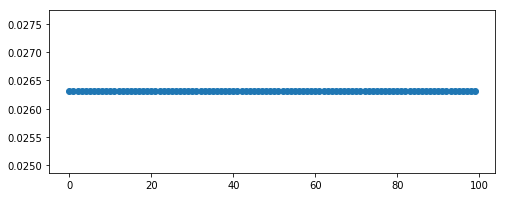

In [140]:
plt.plot(lags,corrs, 'o-')
plt.show()
# something wrong here clearly... 

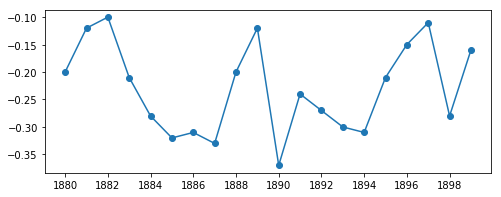

In [101]:
plt.plot(df.GISTEMP[:20],'o-')
plt.show()

### References:

- [Duke resource on differencing](https://people.duke.edu/~rnau/411diff.htm)
- [Scipy talk on time series](https://www.youtube.com/watch?v=v5ijNXvlC5A)
- [Aileen Nielson book](https://www.oreilly.com/library/view/practical-time-series/9781492041641/)

### Check Objectives


In [84]:
monthly = pd.read_csv('monthly_csv.csv')

In [86]:
monthly = monthly.pivot(index='Date', columns='Source', values='Mean')
monthly.head()

Source,GCAG,GISTEMP
Date,,
1880-01-06,0.0009,-0.30
1880-02-06,-0.1229,-0.21
1880-03-06,-0.1357,-0.18
1880-04-06,-0.0499,-0.27
1880-05-06,-0.0738,-0.14


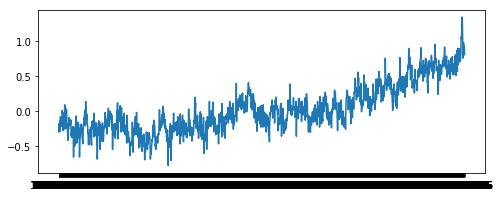

In [102]:
plt.plot(monthly.GISTEMP)
plt.show()